In [160]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import random

# Домашнее задание №6

[Задача 1](#Pr1) \
[Задача 2](#Pr2) \
[Задача 3](#Pr3)

**Задание 1.** Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров. <a class="anchor" id="Pr1"></a>

Загружаем датасет

In [161]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

Делим выборку на обучающую и тестовую

In [162]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Функция предсказания на градиентном бустинге. Предсказание ансамбля деревьев:

$$a_{n}(x) = a_{n-1}(x) + \eta \gamma_{n} b_{n}(x),$$

если $b_0(x) = 0$, то $a_{n}(x) = \sum_{i=1}^{n-1}\eta \gamma_{n} b_{n}(x).$

In [163]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки используем среднеквадратичную ошибку.

In [164]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем в качестве функции потерь
$$L(y, z) = (y-z)^{2},$$
тогда $L'(y, z)_{z} = 2(z-y)$. 

In [165]:
def bias(y, z):
    return (y - z)

Алгоритм построения модели градиентного бустинга:

1. Для инициализации выбираем произвольный простой алгоритм, например $b_{0}(x) = 0$. 

2. Для каждой итерации повторяем:

-- находим предсказания композиции на текущем шаге $z = a_{n-1}(X)$,

-- вычисляем антиградиент функции ошибок $s = -\nabla(L(y,z))= 2(y-z)$,

-- обучаем новый алгоритм алгоритм $b_{n}$ на X, s,

-- находится оптимальный коэффициент $\gamma$
$\gamma_{n} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{n-1}(x_{i}) + \gamma b_{n}(x_{i}))$

и добавляется в имеющийся ансамбль с умножением на шаг $\eta$, называемый скоростью обучения 

$$a_{n}(x) = a_{n-1}(x) + \eta \gamma_{n} b_{n}(x).$$

4. При достижении критериев остановки компонуется итоговая модель
$$a_{N}(x) = \sum^{N}_{n=1}\gamma_{n}b_{n}(x).$$

In [166]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Проанализируем зависимость ошибки от количества деревьев в ансамбле и максимальной глубины деревьев.

In [167]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)} \n')

Исследуем параметр n_trees

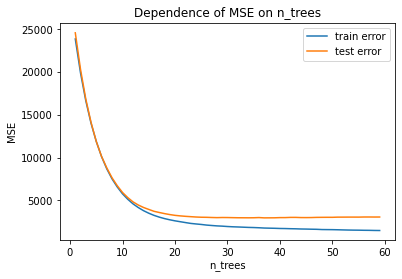

In [168]:
n_trees = 60

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.1

# Максимальная глубина деревьев
max_depth = 3

def prediction_trees(X_train, X_test, y_train, max_depth, y_test, coefs, eta):
    x = np.arange(1,60,1)
    y = [[],[]]
    for i in x:
        trees, train_errors, test_errors = gb_fit(i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        train_err = mean_squared_error(y_train, train_prediction)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        test_err = mean_squared_error(y_test, test_prediction)
        y[0].append(train_err)
        y[1].append(test_err)
    plt.title('Dependence of MSE on n_trees')
    plt.xlabel('n_trees')
    plt.ylabel('MSE')
    plt.plot(x, y[0], label='train error')
    plt.plot(x, y[1], label='test error')
    plt.legend(loc='upper right')
    plt.show()
    
prediction_trees(X_train, X_test, y_train, max_depth, y_test, coefs, eta)

Таким образом, чем больше количество деревьев, тем меньше ошибка. Однако, при заданном max_depth = 2 модель переобучена.

Рассчитаем ошибки с числом деревьев 35

In [184]:
# Число деревьев в ансамбле
n_trees = 35

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 35 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1810.609011174231
Ошибка алгоритма из 35 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2955.0478901424767 



Понизим значение max_depth

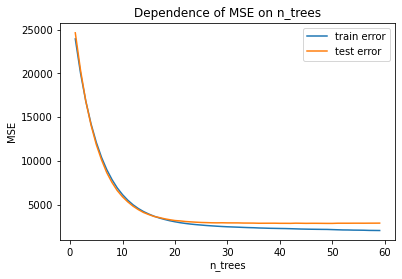

In [185]:
n_trees = 60

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.1

# Максимальная глубина деревьев
max_depth = 2

def prediction_trees(X_train, X_test, y_train, max_depth, y_test, coefs, eta):
    x = np.arange(1,60,1)
    y = [[],[]]
    for i in x:
        trees, train_errors, test_errors = gb_fit(i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        train_err = mean_squared_error(y_train, train_prediction)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        test_err = mean_squared_error(y_test, test_prediction)
        y[0].append(train_err)
        y[1].append(test_err)
    plt.title('Dependence of MSE on n_trees')
    plt.xlabel('n_trees')
    plt.ylabel('MSE')
    plt.plot(x, y[0], label='train error')
    plt.plot(x, y[1], label='test error')
    plt.legend(loc='upper right')
    plt.show()

prediction_trees(X_train, X_test, y_train, max_depth, y_test, coefs, eta)

Таким образом, чем больше количество деревьев, тем меньше ошибка. Но при заданном max_depth = 2 и n_trees>=24 модель начинает переобучаться. 

Рассчитаем ошибки с числом деревьев 23 -- оптимальное значение для max_depth = 2

In [195]:
# Число деревьев в ансамбле
n_trees = 23

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 2

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 23 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2772.275603146106
Ошибка алгоритма из 23 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 3026.2954152870543 



Еще понизим значение max_depth

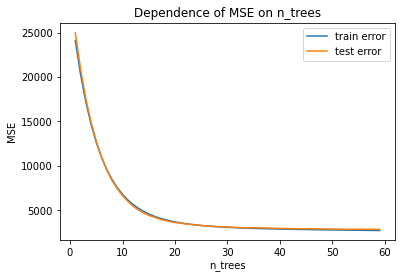

In [196]:
n_trees = 60

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.1

# Максимальная глубина деревьев
max_depth = 1

def prediction_trees(X_train, X_test, y_train, max_depth, y_test, coefs, eta):
    x = np.arange(1,60,1)
    y = [[],[]]
    for i in x:
        trees, train_errors, test_errors = gb_fit(i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        train_err = mean_squared_error(y_train, train_prediction)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        test_err = mean_squared_error(y_test, test_prediction)
        y[0].append(train_err)
        y[1].append(test_err)
    plt.title('Dependence of MSE on n_trees')
    plt.xlabel('n_trees')
    plt.ylabel('MSE')
    plt.plot(x, y[0], label='train error')
    plt.plot(x, y[1], label='test error')
    plt.legend(loc='upper right')
    plt.show()
    
prediction_trees(X_train, X_test, y_train, max_depth, y_test, coefs, eta)

Таким образом, чем больше количество деревьев, тем меньше ошибка. Но при заданном max_depth = 1 модель не переобучена. 

Рассчитаем ошибки с числом деревьев 50 -- оптимальное значение для max_depth = 1

In [203]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 1

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 2785.522184200405
Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 2887.1427126450512 



Наилучшие параметры модели: max_depth = 1, n_trees = 50. Но в такой модели слишком высокое значение n_trees, а MSE не сильно отличается от аналогичного значения для параметров max_depth = 2, n_trees = 23.

Исследуем параметр max_depth для n_trees = 23, 35 и 50

In [211]:
# Число деревьев в ансамбле
n_trees = 35

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.1

def prediction_depth(n_trees, X_train, X_test, y_train, y_test, coefs, eta):
    x = np.arange(1,6,1)
    y = [[],[]]
    for i in x:
        trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        train_err = mean_squared_error(y_train, train_prediction)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        test_err = mean_squared_error(y_test, test_prediction)
        y[0].append(train_err)
        y[1].append(test_err)
    plt.title('Dependence of MSE on max_depth')
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    plt.plot(x, y[0], label='train error')
    plt.plot(x, y[1], label='test error')
    plt.legend(loc='upper right')
    plt.show()

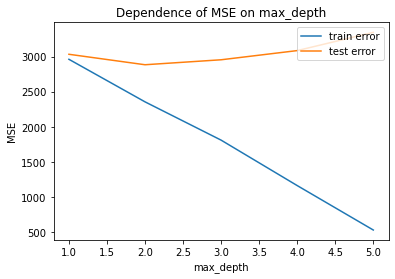

In [212]:
prediction_depth(n_trees, X_train, X_test, y_train, y_test, coefs, eta)

Таким образом, чем больше максимальная глубина дерева, тем меньше ошибка на train. Однако на test при max_depth>=2 значениен MSE монотонно возрастает. Оптимальное значени max_depth равно 1. 

Рассчитаем ошибку для модели с max_depth = 1

In [256]:
# Число деревьев в ансамбле
n_trees = 35

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 1

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 35 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 2961.7966733156136
Ошибка алгоритма из 35 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 3033.356106070442 



In [214]:
# Число деревьев в ансамбле
n_trees = 23

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.1

def prediction_depth(n_trees, X_train, X_test, y_train, y_test, coefs, eta):
    x = np.arange(1,6,1)
    y = [[],[]]
    for i in x:
        trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        train_err = mean_squared_error(y_train, train_prediction)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        test_err = mean_squared_error(y_test, test_prediction)
        y[0].append(train_err)
        y[1].append(test_err)
    plt.title('Dependence of MSE on max_depth')
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    plt.plot(x, y[0], label='train error')
    plt.plot(x, y[1], label='test error')
    plt.legend(loc='upper right')
    plt.show()

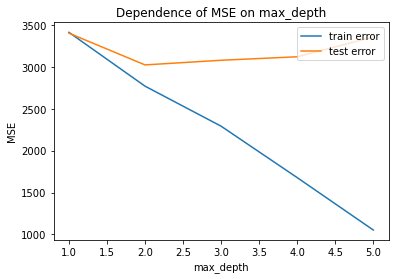

In [215]:
prediction_depth(n_trees, X_train, X_test, y_train, y_test, coefs, eta)

Таким образом, чем больше максимальная глубина дерева, тем меньше ошибка на train. Однако на test при max_depth>=2 значениен MSE монотонно возрастает. Оптимальное значени max_depth равно 2. 

Рассчитаем ошибку для модели с max_depth = 2

In [260]:
# Число деревьев в ансамбле
n_trees = 23

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 2

# Шаг
eta = 0.1

trees_gb, train_errors_gb, test_errors_gb = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees_gb, coefs, eta)

Ошибка алгоритма из 23 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2772.275603146106
Ошибка алгоритма из 23 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 3026.2954152870543 



In [218]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.1

def prediction_depth(n_trees, X_train, X_test, y_train, y_test, coefs, eta):
    x = np.arange(1,6,1)
    y = [[],[]]
    for i in x:
        trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        train_err = mean_squared_error(y_train, train_prediction)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        test_err = mean_squared_error(y_test, test_prediction)
        y[0].append(train_err)
        y[1].append(test_err)
    plt.title('Dependence of MSE on max_depth')
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    plt.plot(x, y[0], label='train error')
    plt.plot(x, y[1], label='test error')
    plt.legend(loc='upper right')
    plt.show()

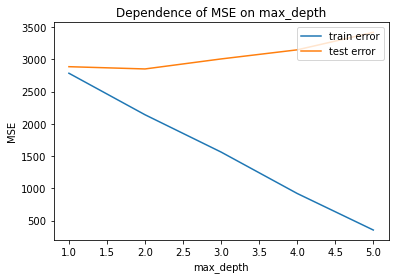

In [219]:
prediction_depth(n_trees, X_train, X_test, y_train, y_test, coefs, eta)

Таким образом, чем больше максимальная глубина дерева, тем меньше ошибка на train. Однако на test при max_depth>=2 значениен MSE монотонно возрастает. Оптимальное значени max_depth равно 1. 

Рассчитаем ошибку для модели с max_depth = 1

In [257]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 1

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 2785.522184200405
Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 2887.1427126450512 



**Ответ:** Чем больше n_trees, тем меньше MSE. Однако, при определенном значении n_trees наступает переобучение. При max_depth>=2 значение MSE монотонно возрастает. Оптимальные значения параметров: n_trees = 23, max_depth = 2 (если ограничений по ресурсам работы модели нет, то параметры n_trees = 50, max_depth = 1 также дадут стабильный результат).

**Задание 2*.** Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.<a class="anchor" id="Pr2"></a>

Функция нахождения подвыборки

In [252]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(len_sample / 2)
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Функция обучения стохастического градиентного бустинга

In [253]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
       
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # генерируем случайныe индексы объектов выборки
        X_train_ind = get_subsample(X_train.shape[0])

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
                  
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[X_train_ind], y_train[X_train_ind])
            
            train_errors.append(mean_squared_error(y_train[X_train_ind], gb_predict(X_train[X_train_ind], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train[X_train_ind], trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[X_train_ind], bias(y_train[X_train_ind], target))
            
            train_errors.append(mean_squared_error(y_train[X_train_ind], gb_predict(X_train[X_train_ind], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Построение модели стохастического градиентного бустинга с оптимальными параметрами, найденными в задаче 1

In [261]:
# Число деревьев в ансамбле
n_trees = 23

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 2

# Шаг
eta = 0.1

trees_sgb, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees_sgb, coefs, eta)

Ошибка алгоритма из 23 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2777.807383308848
Ошибка алгоритма из 23 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 2986.560628396826 



Визуализация кривых изменения ошибки на тестовой выборке градиентного и стохастического градиентного бустингов в зависимости от числа итераций

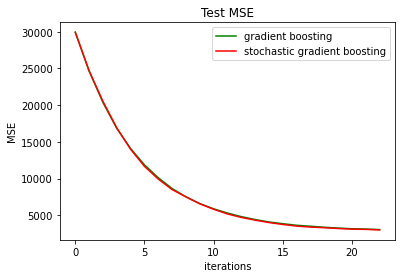

In [266]:
plt.title('Test MSE')
plt.xlabel('iterations')
plt.ylabel('MSE')
plt.plot(test_errors_gb, label='gradient boosting', color = 'g')
plt.plot(test_errors_sgb, label='stochastic gradient boosting', color = 'r')
plt.legend(loc='upper right')
plt.show()

**Вывод:** алгоритм градиентного бустинга работает быстрее, величина MSE на тесте у стохастического градиентного бустинга меньше, чем аналогичный показатель у градиентного бустинга.

**Задание 3*.** Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1. <a class="anchor" id="Pr3"></a>

Алгоритм построения решающего дерева из ДЗ-4 
(см. подробнее задача 3 из HW-4 https://github.com/EkaterinaBazhanova/DAalgorithm/blob/EkaterinaBazhanova-patch-4/HW-4.ipynb)

In [267]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [268]:
# Реаизуем класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        # найдем среднее значение целевой переменной в выборке
        prediction = sum(self.targets) / self.targets.shape[0]
        
        return prediction       

In [269]:
# Расчет дисперсии

def variance(targets):
    # вычислим среднее значение целевого признака
    mean = sum(targets) / targets.shape[0]
        
    #вычисляем дисперсию
    var = 1/targets.shape[0] * sum((targets - mean) ** 2)
    return var

In [270]:
# Расчет качества

def quality(left_targets, right_targets, current_variance):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_targets.shape[0]) / (left_targets.shape[0] + right_targets.shape[0])
    
    return current_variance - p * variance(left_targets) - (1 - p) * variance(right_targets)

In [271]:
# Разбиение датасета в узле

def split(data, targets, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_targets = targets[left]
    false_targets = targets[right]
    
 
    return true_data, false_data, true_targets, false_targets

In [272]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets, min_samples_leaf):
    
    current_variance = variance(targets)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
           
            #  КРИТЕРИЙ ОСТАНОВА: пропускаем разбиения, в которых в узле остается менее  min_samples_leaf объектов
            if len(true_data) <  min_samples_leaf or len(false_data) <  min_samples_leaf:
                continue
            
            current_quality = quality(true_targets, false_targets, current_variance)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [273]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, targets, max_depth, min_samples_leaf, depth = 1):

    #ищем лучшее разбиение
    quality, t, index = find_best_split(data, targets, min_samples_leaf)
    
   # КРИТЕРИЙ ОСТАНОВА: прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, targets)

    #осуществляем разбиение по лучшему найденному
    true_data, false_data, true_targets, false_targets = split(data, targets, index, t)

    # КРИТЕРИЙ ОСТАНОВА: ограничение максимальной глубины дерева
    if depth >= max_depth:
        true_branch = Leaf(true_data, true_targets)
        false_branch = Leaf(false_data, false_targets)
        return Node(index, t, true_branch, false_branch)
           
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_targets, max_depth, min_samples_leaf, depth + 1)
    false_branch = build_tree(false_data, false_targets, max_depth, min_samples_leaf, depth + 1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [274]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [275]:
def predict(data, tree):
    
    targets = []
    for obj in data:
        prediction = classify_object(obj, tree)
        targets.append(prediction)
    return targets

Функция обучения градиентного бустинга (вместо встренного DecisionTreeRegressor используется приведенный выше алгоритм)

In [276]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * predict([x], alg)[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [277]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = build_tree(X_train, y_train,max_depth, 3)
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree(X_train, bias(y_train, target), max_depth, 3)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [278]:
# Число деревьев в ансамбле
n_trees = 23

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 2

# Шаг
eta = 0.1

trees_DT, train_errors, test_errors_DT = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees_DT, coefs, eta)

Ошибка алгоритма из 23 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2781.3017166527284
Ошибка алгоритма из 23 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 3006.707793587619 



Оценка величин MSE на тестовых выборках у двух алгоритмов (задачи 1 и 3)

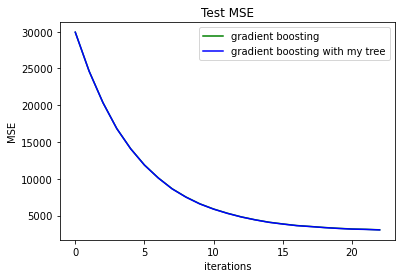

In [282]:
plt.title('Test MSE')
plt.xlabel('iterations')
plt.ylabel('MSE')
plt.plot(test_errors_gb, label='gradient boosting', color = 'g')
plt.plot(test_errors_DT, label='gradient boosting with my tree', color = 'b')
plt.legend(loc='upper right')
plt.show()

**Вывод:**  Значение MSE у градиентного бустинга в задачах 1 и 3 близки. Чуть лучше показатель в задаче 3 (градиентный бустинг с деревом из ДЗ-4).